#Kyrgyz MNIST model to recognize the kyrgyz hand written letters

CNN, BatchNorm, Dropout, Data Augmentation, GPU. The result: 0.98

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import pandas as pd
import numpy as np

# ===============================
# 1. Device
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

BATCH_SIZE = 128
EPOCHS = 30
NUM_CLASSES = 36

# ===============================
# 2. Load data
# ===============================
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_kyrgyz_mnist.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_kyrgyz_mnist.csv")
sample_sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/submission_sample_kyrgyz_mnist.csv")

# labels 1–36 → 0–35
train_df["label"] -= 1
print("Label range:", train_df["label"].min(), train_df["label"].max())

# ===============================
# 3. Dataset + Augmentation
# ===============================
train_tfms = T.Compose([
    T.ToPILImage(),
    T.RandomRotation(10),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor()
])

test_tfms = T.Compose([
    T.ToTensor()
])

class KyrgyzMNISTDataset(Dataset):
    def __init__(self, df, train=True):
        self.train = train
        self.images = df.drop(columns=["id", "label"], errors="ignore") \
                        .values.astype("float32") \
                        .reshape(-1, 50, 50) / 255.0
        if train:
            self.labels = df["label"].values
            self.tfms = train_tfms
        else:
            self.tfms = test_tfms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = self.tfms(img)  # (1, 50, 50)
        if self.train:
            return img, torch.tensor(self.labels[idx], dtype=torch.long)
        return img

train_ds = KyrgyzMNISTDataset(train_df, train=True)
test_ds = KyrgyzMNISTDataset(test_df, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# 4. CNN model
# ===============================
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = CNN().to(DEVICE)

# ===============================
# 5. Loss + Optimizer
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 6. Training
# ===============================
best_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {avg_loss:.4f}")

# ===============================
# 7. Prediction
# ===============================
model.eval()
preds = []

with torch.no_grad():
    for x in test_loader:
        x = x.to(DEVICE)
        out = model(x)
        preds.extend(out.argmax(1).cpu().numpy())

# ===============================
# 8. Submission
# ===============================
sample_sub["label"] = np.array(preds) + 1
path = "/content/drive/MyDrive/Colab Notebooks/submission_cnn_final.csv"
sample_sub.to_csv(path, index=False)

print("Submission saved:", path)


Using device: cuda
Label range: 0 35
Epoch 1/30  Loss: 1.7799
Epoch 2/30  Loss: 0.8255
Epoch 3/30  Loss: 0.6415
Epoch 4/30  Loss: 0.5462
Epoch 5/30  Loss: 0.4849
Epoch 6/30  Loss: 0.4356
Epoch 7/30  Loss: 0.4019
Epoch 8/30  Loss: 0.3691
Epoch 9/30  Loss: 0.3490
Epoch 10/30  Loss: 0.3330
Epoch 11/30  Loss: 0.3075
Epoch 12/30  Loss: 0.2967
Epoch 13/30  Loss: 0.2783
Epoch 14/30  Loss: 0.2671
Epoch 15/30  Loss: 0.2582
Epoch 16/30  Loss: 0.2455
Epoch 17/30  Loss: 0.2406
Epoch 18/30  Loss: 0.2271
Epoch 19/30  Loss: 0.2217
Epoch 20/30  Loss: 0.2171
Epoch 21/30  Loss: 0.2061
Epoch 22/30  Loss: 0.1982
Epoch 23/30  Loss: 0.1940
Epoch 24/30  Loss: 0.1899
Epoch 25/30  Loss: 0.1836
Epoch 26/30  Loss: 0.1789
Epoch 27/30  Loss: 0.1763
Epoch 28/30  Loss: 0.1640
Epoch 29/30  Loss: 0.1635
Epoch 30/30  Loss: 0.1556
Submission saved: /content/drive/MyDrive/Colab Notebooks/submission_cnn_final.csv


In [2]:
MODEL_PATH = "/content/drive/MyDrive/kyrgyz_mnist_cnn_best_15.12.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Модель сохранена")

Модель сохранена


In [4]:
model.eval()


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=4608, out_features=256, bias=True

In [15]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# -------------------------------
# 1️ Предсказания на тесте
# -------------------------------
model.eval()
test_preds = []

with torch.no_grad():
    for x_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        out = model(x_batch)
        preds_batch = out.argmax(1).cpu().numpy()
        test_preds.extend(preds_batch)

# если хочешь посмотреть первые 10 предсказаний
print("Примеры предсказаний (первые 10):", np.array(test_preds[:10])+1)  # +1 чтобы вернуть 1-36

# -------------------------------
# 2️ Accuracy на обучении
# -------------------------------
train_preds = []
train_labels = []

with torch.no_grad():
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        out = model(x_batch)
        pred_batch = out.argmax(1)
        train_preds.extend(pred_batch.cpu().numpy())
        train_labels.extend(y_batch.cpu().numpy())

train_acc = accuracy_score(train_labels, train_preds)
print(f"Train Accuracy: {train_acc:.4f}")

# -------------------------------
# 3️ Confusion matrix
# -------------------------------
cm = confusion_matrix(train_labels, train_preds)
print("Confusion matrix (Train):")
print(cm)

# -------------------------------
# 4️ Подробный classification report
# -------------------------------
report = classification_report(train_labels, train_preds, digits=4)
print("Classification report (Train):")
print(report)

# -------------------------------
# 5️ Loss (если есть сохранённые train_losses)
# -------------------------------
if 'train_losses' in globals():
    print("Последние значения Train Loss:", train_losses[-5:])
else:
    print("Train loss за эпохи не сохранён. Можно добавить сохранение train_losses в обучении.")


Примеры предсказаний (первые 10): [21 11 21 31 19 34 29 19 25 10]
Train Accuracy: 0.9680
Confusion matrix (Train):
[[2085    0    1 ...    0    3   14]
 [   0 2201    2 ...    0    0    0]
 [   1    4 2152 ...    0    3    0]
 ...
 [   0    0    0 ... 2114    3    7]
 [   0    0    0 ...    0 2188    0]
 [   0    0    0 ...    0    1 2230]]
Classification report (Train):
              precision    recall  f1-score   support

           0     0.9863    0.9469    0.9662      2202
           1     0.9675    0.9959    0.9815      2210
           2     0.9881    0.9800    0.9840      2196
           3     0.9915    0.9010    0.9441      2201
           4     0.9590    0.9868    0.9727      2205
           5     0.9665    0.9630    0.9648      2219
           6     0.9888    0.9706    0.9796      2175
           7     0.9595    0.9922    0.9756      2175
           8     0.9678    0.9879    0.9777      2224
           9     0.9648    0.9049    0.9339      2209
          10     0.9838    0.99

Visualization of prediction

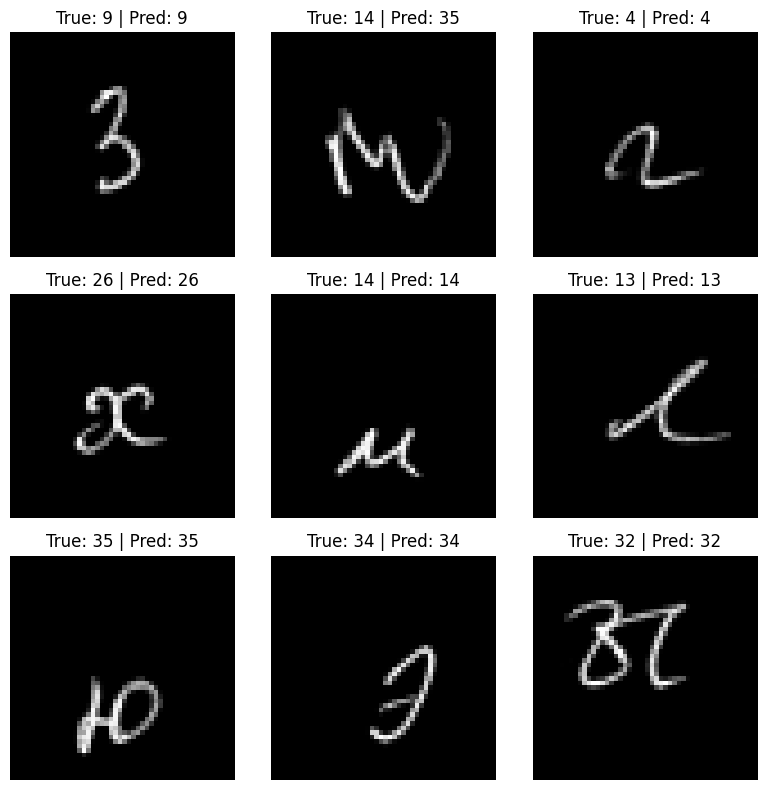

In [7]:
import matplotlib.pyplot as plt
import random

model.eval()

indices = random.sample(range(len(train_df)), 9)

plt.figure(figsize=(8,8))

for i, idx in enumerate(indices):
    row = train_df.iloc[idx]

    # изображение 50×50
    img = row.drop(['label', 'id'], errors='ignore').values.astype('float32').reshape(50,50)
    true_label = row['label'] + 1  # обратно в 1–36

    # 👇 КЛЮЧЕВОЕ МЕСТО
    x = torch.tensor(img / 255.0).unsqueeze(0).unsqueeze(0).to(DEVICE)
    # форма: (1, 1, 50, 50)

    with torch.no_grad():
        pred = model(x).argmax(1).item() + 1

    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label} | Pred: {pred}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
plt.savefig("cnn_predictions.png")


<Figure size 640x480 with 0 Axes>

Confusion matrix

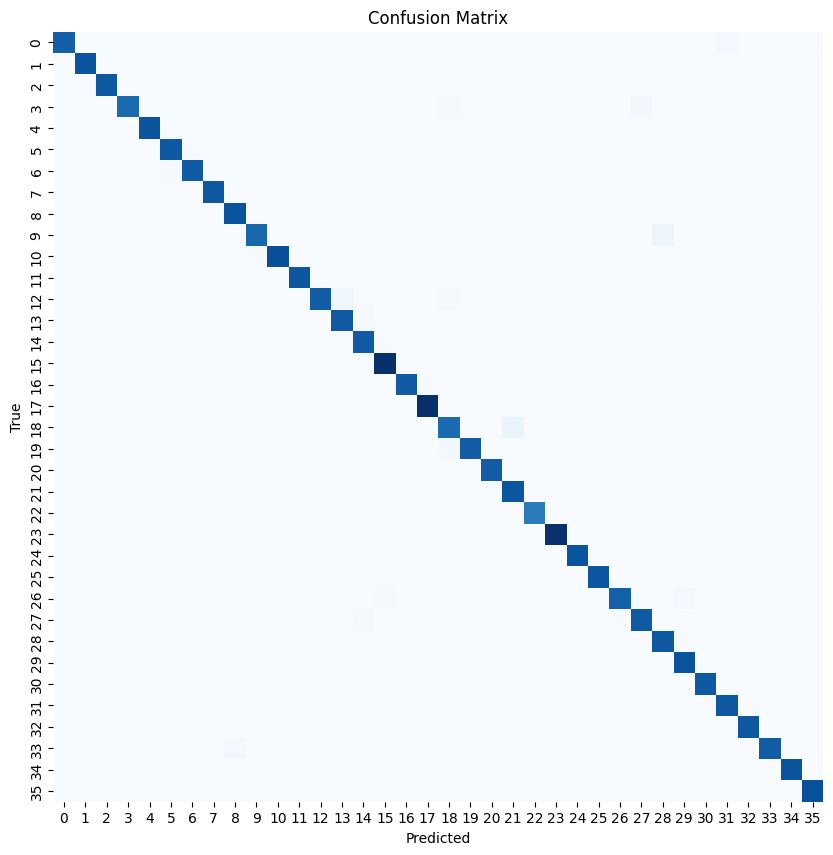

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        preds = out.argmax(1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap="Blues", square=True, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Feature maps

In [11]:
row = train_df.iloc[0]

img = (
    row
    .drop(['id', 'label'], errors='ignore')  # 👈 ключевая строка
    .values
    .astype('float32')
    .reshape(1, 1, 50, 50)
)

x = torch.tensor(img / 255.0).to(DEVICE)


In [13]:
features = []

def hook_fn(module, input, output):
    features.append(output.detach().cpu())

# регистрируем хук на первый Conv слой
hook = model.features[0].register_forward_hook(hook_fn)

# прогоняем одно изображение
model.eval()
with torch.no_grad():
    _ = model(x)   # x shape: [1, 1, 50, 50]

# убираем хук
hook.remove()


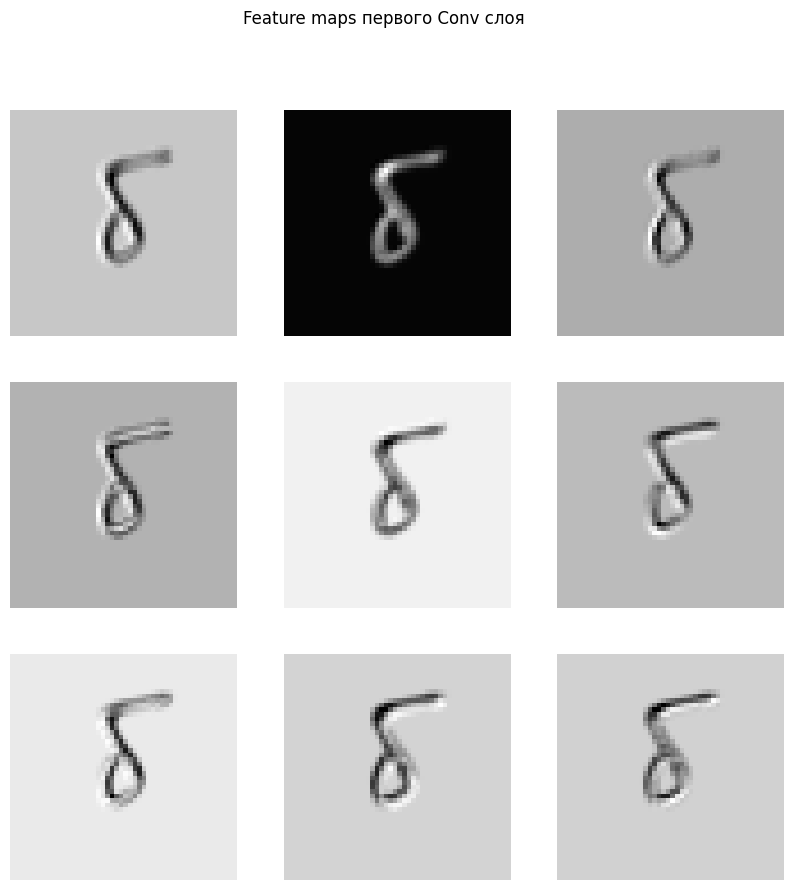

In [14]:
import matplotlib.pyplot as plt

fmaps = features[0][0]  # убираем batch dim → [32, 50, 50]

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(fmaps[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Feature maps первого Conv слоя")
plt.show()
